# Lab 1: Recommender Systems - Movies DB from TMDB
by Group 8: Lu Han, Tony Chan, Michaela Hrabetova, Sangeeta Khanna, Cristina Endara


# Motivation

# Original Source

Work is based on Movie Recommender System by Rounak Banik on [kaggle.com](https://www.kaggle.com/rounakbanik/movie-recommender-systems).

There are modifications to the original work for enhancements, improvements and fixes to make the original code work for both Juypter Notebook and Dash App.


# Notebook Setup

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD

In [2]:
md = pd.read_csv('../input/movies_metadata.csv')
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


## Dataset Characteristics

In [3]:
md.shape

(45466, 24)

In [4]:
md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [5]:
md.nunique()

adult                        5
belongs_to_collection     1698
budget                    1226
genres                    4069
homepage                  7673
id                       45436
imdb_id                  45417
original_language           92
original_title           43373
overview                 44307
popularity               44176
poster_path              45024
production_companies     22708
production_countries      2393
release_date             17336
revenue                   6863
runtime                    353
spoken_languages          1931
status                       6
tagline                  20283
title                    42277
video                        2
vote_average                92
vote_count                1820
dtype: int64

# Basic Data Cleansing

## Data Conversion

In [6]:
# change genres from json format into csv format
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [7]:
# change release_date into date datatype
md['release_date'] = pd.to_datetime(md['release_date'], errors='coerce', format='%Y-%m-%d')
md['release_date'].dt.year

0        1995.0
1        1995.0
2        1995.0
3        1995.0
4        1995.0
          ...  
45461       NaN
45462    2011.0
45463    2003.0
45464    1917.0
45465    2017.0
Name: release_date, Length: 45466, dtype: float64

In [8]:
# change budget to numeric value
md['budget'] = pd.to_numeric(md['budget'], errors='coerce')

In [9]:
# converting popularity to numeric value
md['popularity'] = pd.to_numeric(md['popularity'], errors='coerce')

In [10]:
# change id to numeric value in case we need that
md['id'] = pd.to_numeric(md['id'], errors='coerce')

In [11]:
# change imdb to numeric value in case we need that
md['imdb_id'] = pd.to_numeric(md['imdb_id'], errors='coerce')

In [12]:
md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  45466 non-null  object        
 1   belongs_to_collection  4494 non-null   object        
 2   budget                 45463 non-null  float64       
 3   genres                 45466 non-null  object        
 4   homepage               7782 non-null   object        
 5   id                     45463 non-null  float64       
 6   imdb_id                3 non-null      float64       
 7   original_language      45455 non-null  object        
 8   original_title         45466 non-null  object        
 9   overview               44512 non-null  object        
 10  popularity             45460 non-null  float64       
 11  poster_path            45080 non-null  object        
 12  production_companies   45463 non-null  object        
 13  p

# Removing Data

In [13]:
# removing movies with no id. It has no useful info anyways
md[md['id'].isna()]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19730,- Written by Ørnås,0.065736,NaN,"[Carousel Productions, Vision View Entertainme...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",NaN,0.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,NaN,"[Aniplex, GoHands, BROSTA TV, Mardock Scramble...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,0.0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,NaN,"[Odyssey Media, Pulser Productions, Rogue Stat...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",NaN,0.0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# will remove those that doesn't have a release date
md[md['release_date'].isna()].shape

(90, 24)

In [15]:
md.adult.unique()

array(['False', 'True', ' - Written by Ørnås',
       ' Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.',
       ' Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.'],
      dtype=object)

In [16]:
# dropping rows that are weird and adult content
df_remove = md[md['adult'] != 'False']
md = md.drop(df_remove.index, axis=0)

In [17]:
# we have this number of records that do not have revenue data... which is a lot
md[md['revenue'] == 0].shape

(38043, 24)

In [18]:
md['revenue'].isna().sum()

3

In [19]:
md[md['revenue'].isna()]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19729,False,NaN,0.0,"[Action, Thriller, Drama]",NaN,82663.0,NaN,en,Midnight Man,British soldiers force a recently captured IRA...,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29502,False,"{'id': 122661, 'name': 'Mardock Scramble Colle...",0.0,"[Animation, Science Fiction]",http://m-scramble.jp/exhaust/,122662.0,NaN,ja,マルドゥック・スクランブル 排気,Third film of the Mardock Scramble series.,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35586,False,NaN,0.0,"[TV Movie, Action, Horror, Science Fiction]",NaN,249260.0,NaN,en,Avalanche Sharks,A group of skiers are terrorized during spring...,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#shape before
md.shape

(45454, 24)

In [21]:
# removing those records that is NaN but not 0. It seem records is not important and with errors
md.dropna(subset=['revenue', 'id', 'release_date'], inplace=True)

In [22]:
#shape after
md.shape

(45368, 24)

In [23]:
# we will make id an integer type for easy lookup later.
md['id'] = md['id'].astype(int)

In [24]:
md['status'].unique()

array(['Released', nan, 'Rumored', 'Post Production', 'In Production',
       'Planned', 'Canceled'], dtype=object)

In [25]:
# we are only interested in movies that are released. we will drop all those that are not marked as 'Released'
df_remove = md[md['status'] != 'Released']
md = md.drop(df_remove.index, axis=0)

In [26]:
md.shape

(44928, 24)

In [27]:
print('Newest movie in DB: ', md['title'][md['release_date'] == md['release_date'].max()])
print('Dated: ', md['release_date'].max())

print('Oldest movie in DB: ', md['title'][md['release_date'] == md['release_date'].min()])
print('Dated: ', md['release_date'].min())

Newest movie in DB:  44301    How to Talk to Girls at Parties
Name: title, dtype: object
Dated:  2017-12-27 00:00:00
Oldest movie in DB:  34940    Passage of Venus
Name: title, dtype: object
Dated:  1874-12-09 00:00:00


# Data Exploration

## Franchise Movies  

This example is taken [Story of Film](https://www.kaggle.com/rounakbanik/the-story-of-film/). It has some interesting information that we might need in the upcoming analysis and thus we include this in our study.

In [28]:
import ast
md_franchise = md[md['belongs_to_collection'].notnull()]
md_franchise['belongs_to_collection'] = md_franchise['belongs_to_collection'].apply(ast.literal_eval).apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)
md_franchise = md_franchise[md_franchise['belongs_to_collection'].notnull()]

In [29]:
pt_franchise = md_franchise.pivot_table(index='belongs_to_collection', values='revenue', aggfunc={'revenue': ['mean', 'sum', 'count']}).reset_index()

### Revenue of Franchise Movies

In [30]:
pt_franchise.sort_values('sum', ascending=False).head(10)

,belongs_to_collection,count,mean,sum
551,Harry Potter Collection,8,9.634209e+08,7.707367e+09
1157,Star Wars Collection,8,9.293118e+08,7.434495e+09
645,James Bond Collection,26,2.733450e+08,7.106970e+09
1314,The Fast and the Furious Collection,8,6.406373e+08,5.125099e+09
965,Pirates of the Caribbean Collection,5,9.043154e+08,4.521577e+09
1546,Transformers Collection,5,8.732202e+08,4.366101e+09
325,Despicable Me Collection,6,6.151784e+08,3.691070e+09
1487,The Twilight Collection,5,6.684215e+08,3.342107e+09
609,Ice Age Collection,5,6.433417e+08,3.216709e+09
665,Jurassic Park Collection,4,7.578710e+08,3.031484e+09


### Budget of Franchise Movies

In [31]:
pt2_franchise = md_franchise.pivot_table(index='belongs_to_collection', values='budget', aggfunc={'budget': ['mean', 'sum', 'count']}).reset_index()

In [32]:
pt2_franchise.sort_values('sum', ascending=False).head(10)

,belongs_to_collection,count,mean,sum
645,James Bond Collection,26,5.921731e+07,1.539650e+09
551,Harry Potter Collection,8,1.600000e+08,1.280000e+09
965,Pirates of the Caribbean Collection,5,2.500000e+08,1.250000e+09
1314,The Fast and the Furious Collection,8,1.261250e+08,1.009000e+09
1652,X-Men Collection,6,1.638333e+08,9.830000e+08
1546,Transformers Collection,5,1.930000e+08,9.650000e+08
1157,Star Wars Collection,8,1.067938e+08,8.543500e+08
1349,The Hobbit Collection,3,2.500000e+08,7.500000e+08
1479,The Terminator Collection,5,1.322800e+08,6.614000e+08
832,Mission: Impossible Collection,5,1.300000e+08,6.500000e+08


## Data Visualizations

In [33]:
# md.describe(include='all')
md.describe()

,budget,id,imdb_id,popularity,revenue,runtime,vote_average,vote_count
count,4.492800e+04,44928.000000,0.0,44928.000000,4.492800e+04,44688.000000,44928.000000,44928.000000
mean,4.273267e+06,107766.245949,NaN,2.944232,1.134057e+07,94.318206,5.629679,111.097445
std,1.752146e+07,112011.236129,NaN,6.027912,6.470045e+07,38.301023,1.907316,494.078499
min,0.000000e+00,2.000000,NaN,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,26172.750000,NaN,0.394084,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,59528.000000,NaN,1.138981,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,156573.750000,NaN,3.741004,0.000000e+00,107.000000,6.800000,35.000000
max,3.800000e+08,469172.000000,NaN,547.488298,2.787965e+09,1256.000000,10.000000,14075.000000


In [34]:
md['popularity'].describe()

count    44928.000000
mean         2.944232
std          6.027912
min          0.000000
25%          0.394084
50%          1.138981
75%          3.741004
max        547.488298
Name: popularity, dtype: float64

## Top Movies (by Popularity Rating)

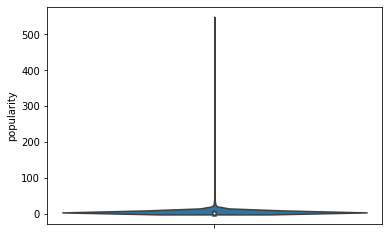

In [35]:
sns.violinplot(y='popularity', data=md)

Text(0.5, 1.0, 'popularity')

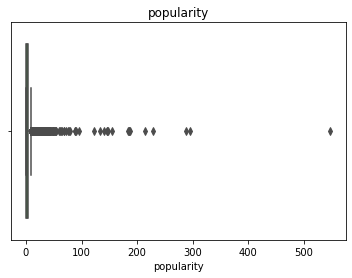

In [36]:
sns.boxplot(x=md['popularity'], color='lime').set_title("popularity")

In [37]:
md[['title', 'release_date', 'popularity']].sort_values('popularity', ascending=False).head(10)

,title,release_date,popularity
30700,Minions,2015-06-17,547.488298
33356,Wonder Woman,2017-05-30,294.337037
42222,Beauty and the Beast,2017-03-16,287.253654
43644,Baby Driver,2017-06-28,228.032744
24455,Big Hero 6,2014-10-24,213.849907
26564,Deadpool,2016-02-09,187.860492
26566,Guardians of the Galaxy Vol. 2,2017-04-19,185.330992
14551,Avatar,2009-12-10,185.070892
24351,John Wick,2014-10-22,183.870374
23675,Gone Girl,2014-10-01,154.801009


It seems that popularity rating has been skewed towards recent movie titles. We will have to weight in when we try to build a recommender system based on this rating.

In [38]:
md[md['popularity'] == 0].shape

(38, 24)

In [39]:
md[md['popularity'] <= 1].shape

(20840, 24)

There are 40 titles that has 0 popularity rating, and they are all released in 70s, 80s, 90s. (check by running md[md['popularity'] == 0]). There are about 50% of movies that has popularity < 3. This, again, proves that most people prefer to watch newer movies.

### Top Movies (by Most Voted)

In [40]:
md[['title', 'release_date', 'vote_count']].sort_values('vote_count', ascending=False).head(10)

,title,release_date,vote_count
15480,Inception,2010-07-14,14075.0
12481,The Dark Knight,2008-07-16,12269.0
14551,Avatar,2009-12-10,12114.0
17818,The Avengers,2012-04-25,12000.0
26564,Deadpool,2016-02-09,11444.0
22879,Interstellar,2014-11-05,11187.0
20051,Django Unchained,2012-12-25,10297.0
23753,Guardians of the Galaxy,2014-07-30,10014.0
2843,Fight Club,1999-10-15,9678.0
18244,The Hunger Games,2012-03-12,9634.0


## Top Movies (by Highest Vote Average)

In [41]:
md['vote_count'].quantile(0.995)

3471.729999999996

we will use top 0.5% quantile vote_count to qualify good movies, which is about 45k * 0.5% ~ 220 movies that has been voted for.

In [42]:
md[md['vote_count'] > md['vote_count'].quantile(0.995)][['title', 'release_date', 'vote_average', 'vote_count' ]].sort_values('vote_average', ascending=False).head(10)

,title,release_date,vote_average,vote_count
834,The Godfather,1972-03-14,8.5,6024.0
314,The Shawshank Redemption,1994-09-23,8.5,8358.0
522,Schindler's List,1993-11-29,8.3,4436.0
12481,The Dark Knight,2008-07-16,8.3,12269.0
2211,Life Is Beautiful,1997-12-20,8.3,3643.0
2843,Fight Club,1999-10-15,8.3,9678.0
23673,Whiplash,2014-10-10,8.3,4376.0
292,Pulp Fiction,1994-09-10,8.3,8670.0
5481,Spirited Away,2001-07-20,8.3,3968.0
351,Forrest Gump,1994-07-06,8.2,8147.0


## Genre Analysis

In [43]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

In [44]:
s = s.to_frame()

In [45]:
s.columns = ['genre']

In [46]:
s['genre'].unique()

array(['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance',
       'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History',
       'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music',
       'Documentary', 'Western', 'TV Movie'], dtype=object)

In [47]:
s['genre'].value_counts()

Drama              20070
Comedy             13075
Thriller            7568
Romance             6665
Action              6545
Horror              4632
Crime               4280
Documentary         3863
Adventure           3473
Science Fiction     3015
Family              2741
Mystery             2453
Fantasy             2294
Animation           1915
Music               1587
Foreign             1587
History             1391
War                 1318
Western             1038
TV Movie             759
Name: genre, dtype: int64

## Generate a Tag Cloud from Genre

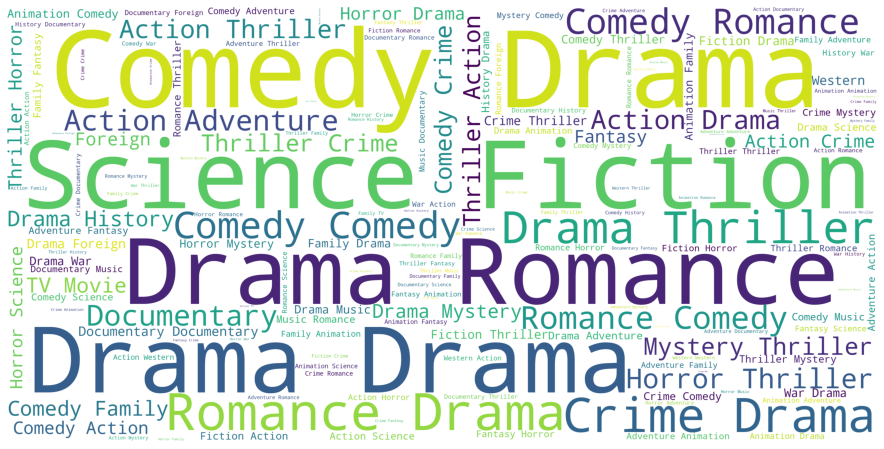

In [48]:
from wordcloud import WordCloud, STOPWORDS
genre_corpus = ' '.join(s['genre'])
genre_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(genre_corpus)
plt.figure(figsize=(16,8))
plt.imshow(genre_wordcloud)
plt.axis('off')
plt.show()

In [50]:
# We save our cleaned csv for the next steps
# md.to_csv('../input/movies_cleaned.csv')